# 8 Pilares Estadisticos: Evaluacion de Tipo de Cambio

**Traduciendo conceptos academicos para Data Science al mundo real**

Este notebook evalua los datos de Tipo de Cambio procesados por `ETL_Principales.py`:

1. **Distribuciones** - Forma de los datos
2. **Centro de Gravedad** - Media, Mediana, Moda
3. **Fiabilidad** - Riesgo y volatilidad
4. **Margen de Error** - Intervalos de confianza
5. **Pruebas de Hipotesis** - Chi-cuadrada
6. **Regresion/Prediccion** - Machine Learning
7. **Series de Tiempo** - Tendencias y estacionalidad
8. **ANOVA** - Comparacion entre grupos

**Variables:**
- tcn_mean: Tipo de cambio promedio del trimestre
- tcn_eop: Tipo de cambio fin de periodo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from scipy.stats import chi2_contingency, shapiro, normaltest, kruskal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

BASE_DIR = Path('..').resolve()
DATOS_RESULTADO = BASE_DIR / 'Datos_Resultado'
print(f"Directorio: {BASE_DIR}")

Directorio: C:\Users\ARTUROJF\Desktop\Final


## Carga de Datos

In [2]:
path_datos = DATOS_RESULTADO / 'TipoCambio_Trimestral.csv'
df = pd.read_csv(path_datos) if path_datos.exists() else pd.DataFrame()

print(f"Datos: {len(df)} filas x {len(df.columns)} columnas")
print(f"Columnas: {df.columns.tolist()}")
df.head(10)

Datos: 136 filas x 3 columnas
Columnas: ['periodo', 'tcn_mean', 'tcn_eop']


,periodo,tcn_mean,tcn_eop
0,1991-10-01,3.0694,3.0703
1,1992-01-01,3.0660,3.0667
2,1992-04-01,3.0958,3.1188
3,1992-07-01,3.0979,3.0878
4,1992-10-01,3.1190,3.1186
5,1993-01-01,3.1053,3.1082
6,1993-04-01,3.1136,3.1212
7,1993-07-01,3.1163,3.1130
8,1993-10-01,3.1256,3.1078
9,1994-01-01,3.1717,3.2910


In [3]:
df['periodo'] = pd.to_datetime(df['periodo'])
df = df.sort_values('periodo').reset_index(drop=True)
df['TRIMESTRE'] = df['periodo'].dt.quarter
df['year'] = df['periodo'].dt.year

cols_numericas = ['tcn_mean', 'tcn_eop']
cols_numericas = [c for c in cols_numericas if c in df.columns]

# Calcular rendimiento/depreciacion
if 'tcn_mean' in df.columns:
    df['depreciacion_pct'] = df['tcn_mean'].pct_change() * 100
    df['depreciacion_yoy'] = df['tcn_mean'].pct_change(4) * 100

VAR_PRINCIPAL = 'tcn_mean'
print(f"Variable principal: {VAR_PRINCIPAL}")
print(f"Periodo: {df['periodo'].min()} a {df['periodo'].max()}")
print(f"Rango TCN: {df[VAR_PRINCIPAL].min():.2f} - {df[VAR_PRINCIPAL].max():.2f} MXN/USD")
df[cols_numericas].describe()

Variable principal: tcn_mean
Periodo: 1991-10-01 00:00:00 a 2025-07-01 00:00:00
Rango TCN: 3.07 - 23.34 MXN/USD


,tcn_mean,tcn_eop
count,136.000000,136.000000
mean,12.581994,12.654261
std,5.210679,5.213238
min,3.066000,3.066700
25%,9.437325,9.417275
50%,11.589850,11.642700
75%,17.731950,17.724025
max,23.337200,22.257500


---
## PILAR 1: Distribuciones

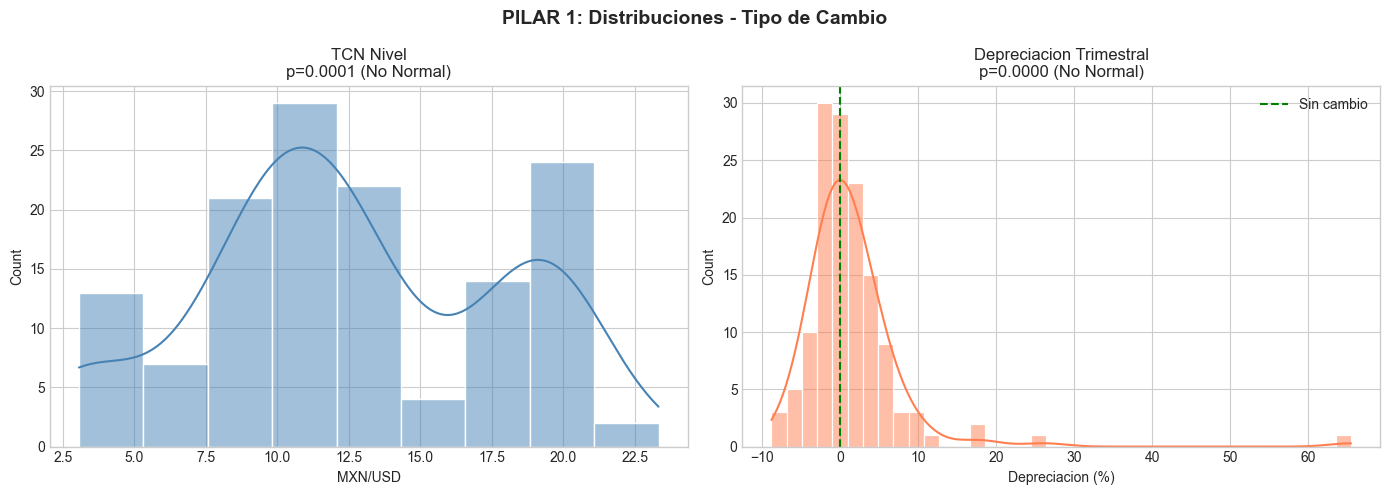


RESUMEN DE NORMALIDAD:
tcn_mean             | p=0.0001 | No Normal
tcn_eop              | p=0.0001 | No Normal
depreciacion_pct     | p=0.0000 | No Normal


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('PILAR 1: Distribuciones - Tipo de Cambio', fontsize=14, fontweight='bold')

# TCN nivel
data = df[VAR_PRINCIPAL].dropna()
sns.histplot(data, kde=True, ax=axes[0], color='steelblue', edgecolor='white')
if len(data) >= 20:
    _, p = shapiro(data) if len(data) < 5000 else normaltest(data)
    axes[0].set_title(f'TCN Nivel\np={p:.4f} ({"Normal" if p > 0.05 else "No Normal"})')
axes[0].set_xlabel('MXN/USD')

# Depreciacion
if 'depreciacion_pct' in df.columns:
    data2 = df['depreciacion_pct'].dropna()
    sns.histplot(data2, kde=True, ax=axes[1], color='coral', edgecolor='white')
    if len(data2) >= 20:
        _, p2 = shapiro(data2) if len(data2) < 5000 else normaltest(data2)
        axes[1].set_title(f'Depreciacion Trimestral\np={p2:.4f} ({"Normal" if p2 > 0.05 else "No Normal"})')
    axes[1].axvline(0, color='green', linestyle='--', label='Sin cambio')
    axes[1].set_xlabel('Depreciacion (%)')
    axes[1].legend()

plt.tight_layout()
plt.show()

print("\nRESUMEN DE NORMALIDAD:")
for var in cols_numericas + ['depreciacion_pct']:
    if var in df.columns:
        data = df[var].dropna()
        if len(data) >= 20:
            _, p = shapiro(data) if len(data) < 5000 else normaltest(data)
            print(f"{var:20} | p={p:.4f} | {'Normal' if p > 0.05 else 'No Normal'}")

---
## PILAR 2: Centro de Gravedad

In [5]:
print("PILAR 2: MEDIDAS DE TENDENCIA CENTRAL")
print("="*60)

stats_centro = []
for var in cols_numericas + ['depreciacion_pct', 'depreciacion_yoy']:
    if var in df.columns:
        data = df[var].dropna()
        stats_centro.append({
            'Variable': var,
            'Media': data.mean(),
            'Mediana': data.median(),
            'Desv. Std': data.std(),
            'Ultimo': data.iloc[-1] if len(data) > 0 else np.nan
        })

pd.DataFrame(stats_centro)

PILAR 2: MEDIDAS DE TENDENCIA CENTRAL


,Variable,Media,Mediana,Desv. Std,Ultimo
0,tcn_mean,12.581994,11.589850,5.210679,18.640000
1,tcn_eop,12.654261,11.642700,5.213238,18.513800
2,depreciacion_pct,1.556341,0.404791,7.270916,-4.573705
3,depreciacion_yoy,6.904576,2.313526,17.697302,-1.604730


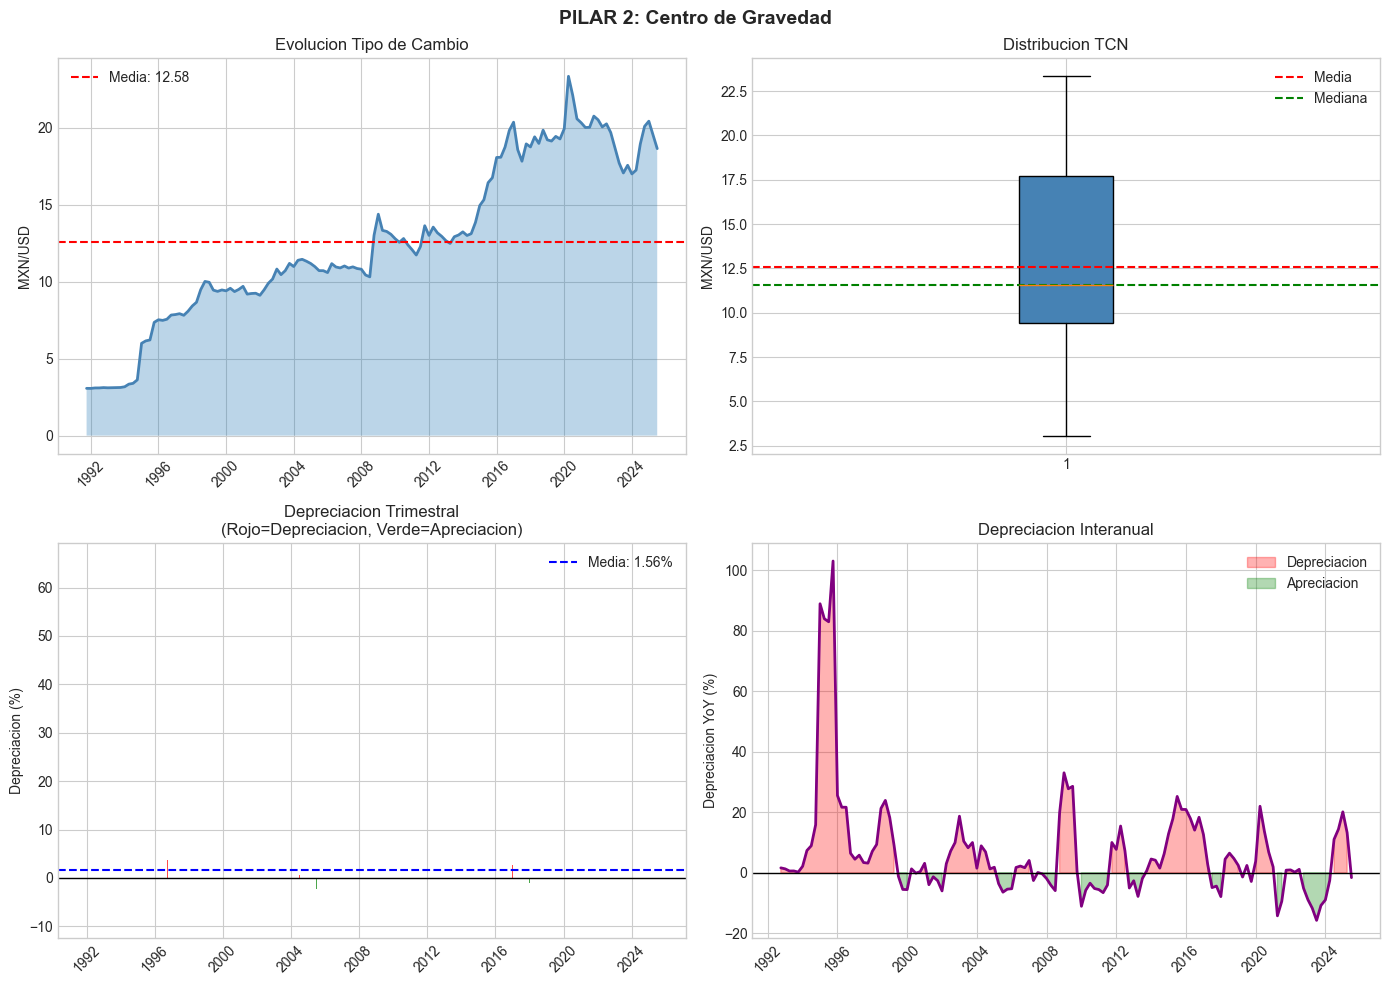

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('PILAR 2: Centro de Gravedad', fontsize=14, fontweight='bold')

# Evolucion TCN
axes[0, 0].plot(df['periodo'], df[VAR_PRINCIPAL], color='steelblue', linewidth=2)
axes[0, 0].axhline(df[VAR_PRINCIPAL].mean(), color='red', linestyle='--', label=f'Media: {df[VAR_PRINCIPAL].mean():.2f}')
axes[0, 0].fill_between(df['periodo'], df[VAR_PRINCIPAL], alpha=0.3)
axes[0, 0].set_ylabel('MXN/USD')
axes[0, 0].set_title('Evolucion Tipo de Cambio')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)

# Boxplot TCN
bp = axes[0, 1].boxplot(df[VAR_PRINCIPAL].dropna(), patch_artist=True)
bp['boxes'][0].set_facecolor('steelblue')
axes[0, 1].axhline(df[VAR_PRINCIPAL].mean(), color='red', linestyle='--', label=f'Media')
axes[0, 1].axhline(df[VAR_PRINCIPAL].median(), color='green', linestyle='--', label=f'Mediana')
axes[0, 1].set_ylabel('MXN/USD')
axes[0, 1].set_title('Distribucion TCN')
axes[0, 1].legend()

# Depreciacion trimestral
if 'depreciacion_pct' in df.columns:
    dep = df['depreciacion_pct'].dropna()
    colors = ['red' if d > 0 else 'green' for d in dep]
    axes[1, 0].bar(df.loc[dep.index, 'periodo'], dep, color=colors, alpha=0.7)
    axes[1, 0].axhline(0, color='black', linewidth=1)
    axes[1, 0].axhline(dep.mean(), color='blue', linestyle='--', label=f'Media: {dep.mean():.2f}%')
    axes[1, 0].set_ylabel('Depreciacion (%)')
    axes[1, 0].set_title('Depreciacion Trimestral\n(Rojo=Depreciacion, Verde=Apreciacion)')
    axes[1, 0].legend()
    axes[1, 0].tick_params(axis='x', rotation=45)

# Depreciacion YoY
if 'depreciacion_yoy' in df.columns:
    dep_yoy = df['depreciacion_yoy'].dropna()
    axes[1, 1].plot(df.loc[dep_yoy.index, 'periodo'], dep_yoy, color='purple', linewidth=2)
    axes[1, 1].axhline(0, color='black', linewidth=1)
    axes[1, 1].fill_between(df.loc[dep_yoy.index, 'periodo'], dep_yoy, 0, 
                            where=dep_yoy > 0, alpha=0.3, color='red', label='Depreciacion')
    axes[1, 1].fill_between(df.loc[dep_yoy.index, 'periodo'], dep_yoy, 0, 
                            where=dep_yoy < 0, alpha=0.3, color='green', label='Apreciacion')
    axes[1, 1].set_ylabel('Depreciacion YoY (%)')
    axes[1, 1].set_title('Depreciacion Interanual')
    axes[1, 1].legend()
    axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

---
## PILAR 3: Fiabilidad

In [7]:
print("PILAR 3: FIABILIDAD Y VOLATILIDAD")
print("="*60)

data = df[VAR_PRINCIPAL].dropna()
cv = data.std() / data.mean() * 100
Q1, Q3 = data.quantile([0.25, 0.75])
IQR = Q3 - Q1
outliers = ((data < Q1 - 1.5*IQR) | (data > Q3 + 1.5*IQR)).sum()

print(f"TCN - Coeficiente de Variacion: {cv:.1f}%")
print(f"TCN - Outliers: {outliers}")

if 'depreciacion_pct' in df.columns:
    dep = df['depreciacion_pct'].dropna()
    print(f"\nDepreciacion trimestral:")
    print(f"  - Promedio: {dep.mean():.2f}%")
    print(f"  - Volatilidad (Desv.Std): {dep.std():.2f}%")
    print(f"  - Peor trimestre: {dep.max():.2f}%")
    print(f"  - Mejor trimestre: {dep.min():.2f}%")

PILAR 3: FIABILIDAD Y VOLATILIDAD
TCN - Coeficiente de Variacion: 41.4%
TCN - Outliers: 0

Depreciacion trimestral:
  - Promedio: 1.56%
  - Volatilidad (Desv.Std): 7.27%
  - Peor trimestre: 65.49%
  - Mejor trimestre: -8.77%


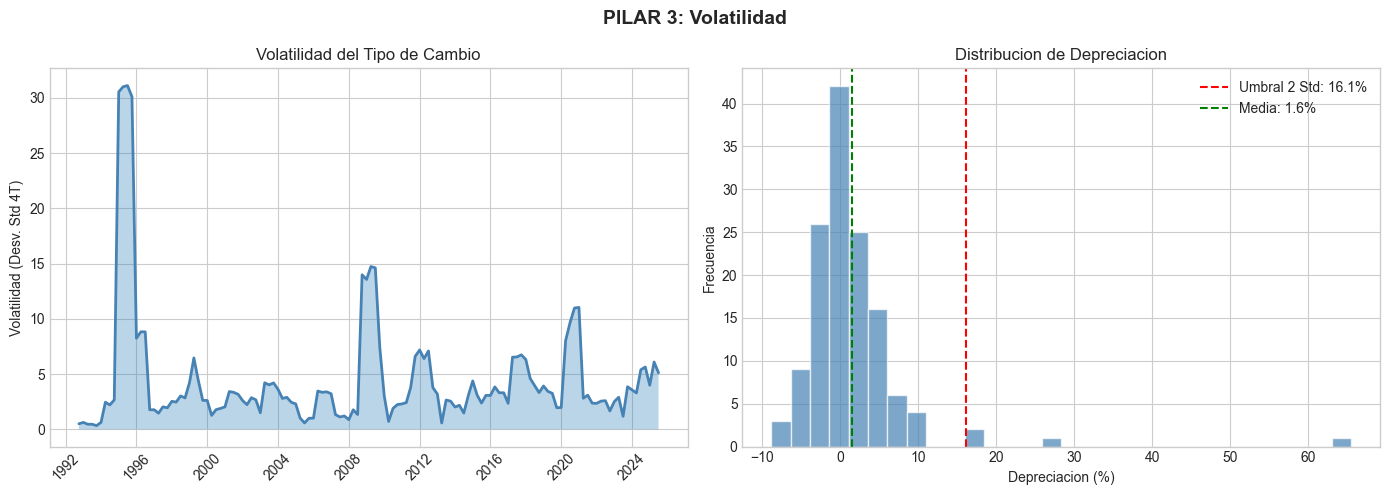


Eventos de alta depreciacion (>16.1%):
   periodo  depreciacion_pct
1995-01-01         65.486872
1995-10-01         18.418426
2008-10-01         26.186505
2020-04-01         17.071751


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('PILAR 3: Volatilidad', fontsize=14, fontweight='bold')

# Rolling volatilidad
if 'depreciacion_pct' in df.columns:
    vol = df['depreciacion_pct'].rolling(4).std()
    axes[0].plot(df['periodo'], vol, color='steelblue', linewidth=2)
    axes[0].fill_between(df['periodo'], vol, alpha=0.3)
    axes[0].set_ylabel('Volatilidad (Desv. Std 4T)')
    axes[0].set_title('Volatilidad del Tipo de Cambio')
    axes[0].tick_params(axis='x', rotation=45)

# Eventos de alta volatilidad
if 'depreciacion_pct' in df.columns:
    dep = df['depreciacion_pct'].dropna()
    umbral = dep.mean() + 2 * dep.std()
    eventos = df[df['depreciacion_pct'] > umbral][['periodo', 'depreciacion_pct']]
    
    axes[1].hist(dep, bins=30, color='steelblue', edgecolor='white', alpha=0.7)
    axes[1].axvline(umbral, color='red', linestyle='--', label=f'Umbral 2 Std: {umbral:.1f}%')
    axes[1].axvline(dep.mean(), color='green', linestyle='--', label=f'Media: {dep.mean():.1f}%')
    axes[1].set_xlabel('Depreciacion (%)')
    axes[1].set_ylabel('Frecuencia')
    axes[1].set_title('Distribucion de Depreciacion')
    axes[1].legend()

plt.tight_layout()
plt.show()

if len(eventos) > 0:
    print(f"\nEventos de alta depreciacion (>{umbral:.1f}%):")
    print(eventos.to_string(index=False))

---
## PILAR 4: Margen de Error

In [9]:
print("PILAR 4: INTERVALOS DE CONFIANZA (95%)")
print("="*60)

def ic(data, conf=0.95):
    n = len(data)
    m = data.mean()
    se = stats.sem(data)
    h = se * stats.t.ppf((1 + conf) / 2, n - 1)
    return m - h, m + h, h

for var in cols_numericas + ['depreciacion_pct']:
    if var in df.columns:
        data = df[var].dropna()
        if len(data) >= 10:
            low, high, margin = ic(data)
            unit = 'MXN/USD' if 'tcn' in var else '%'
            print(f"{var:20}: {data.mean():.2f} [{low:.2f}, {high:.2f}] {unit}")

PILAR 4: INTERVALOS DE CONFIANZA (95%)
tcn_mean            : 12.58 [11.70, 13.47] MXN/USD
tcn_eop             : 12.65 [11.77, 13.54] MXN/USD
depreciacion_pct    : 1.56 [0.32, 2.79] %


---
## PILAR 5: Pruebas de Hipotesis

In [10]:
print("PILAR 5: PRUEBAS DE HIPOTESIS")
print("="*60)

df_test = df.copy()

# Categorizar direccion del tipo de cambio
if 'depreciacion_pct' in df_test.columns:
    df_test['direccion'] = df_test['depreciacion_pct'].apply(
        lambda x: 'Depreciacion' if x > 1 else 'Apreciacion' if x < -1 else 'Estable')
    
    print("\n--- H1: Direccion TCN vs Trimestre ---")
    contingencia = pd.crosstab(df_test['direccion'].dropna(), df_test.loc[df_test['direccion'].notna(), 'TRIMESTRE'])
    print(contingencia)
    
    if contingencia.shape[0] > 1 and contingencia.shape[1] > 1:
        chi2, p_value, _, _ = chi2_contingency(contingencia)
        print(f"\nChi2={chi2:.4f}, p={p_value:.4f}")
        print(f"{'RECHAZAR H0' if p_value < 0.05 else 'NO RECHAZAR H0'}")
    else:
        p_value = 1.0
else:
    p_value = 1.0

PILAR 5: PRUEBAS DE HIPOTESIS

--- H1: Direccion TCN vs Trimestre ---
TRIMESTRE      1   2   3   4
direccion                   
Apreciacion   14  16  11   6
Depreciacion  14  12  13  19
Estable        6   6  10   9

Chi2=8.4749, p=0.2053
NO RECHAZAR H0


In [11]:
# H2: Crisis cambiarias por decada
print("\n--- H2: Eventos de crisis por decada ---")
if 'depreciacion_pct' in df_test.columns:
    df_test['decada'] = (df_test['year'] // 10) * 10
    umbral = df_test['depreciacion_pct'].mean() + 2 * df_test['depreciacion_pct'].std()
    df_test['crisis'] = df_test['depreciacion_pct'].apply(lambda x: 'Crisis' if x > umbral else 'Normal')
    
    contingencia2 = pd.crosstab(df_test['crisis'].dropna(), df_test.loc[df_test['crisis'].notna(), 'decada'])
    print(contingencia2)
    
    if contingencia2.shape[0] > 1 and contingencia2.shape[1] > 1:
        chi2_2, p_value_2, _, _ = chi2_contingency(contingencia2)
        print(f"\nChi2={chi2_2:.4f}, p={p_value_2:.6f}")
    else:
        p_value_2 = 1.0
else:
    p_value_2 = 1.0


--- H2: Eventos de crisis por decada ---
decada  1990  2000  2010  2020
crisis                        
Crisis     2     1     0     1
Normal    31    39    40    22

Chi2=2.5237, p=0.471023


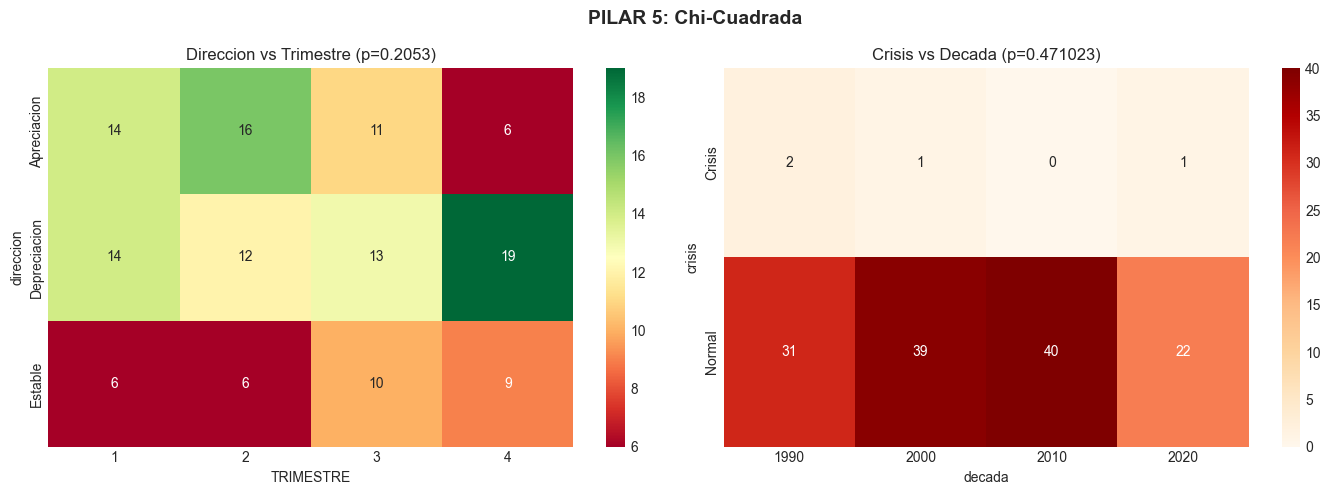

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('PILAR 5: Chi-Cuadrada', fontsize=14, fontweight='bold')

if 'direccion' in df_test.columns:
    sns.heatmap(contingencia, annot=True, fmt='d', cmap='RdYlGn', ax=axes[0])
    axes[0].set_title(f'Direccion vs Trimestre (p={p_value:.4f})')

if 'crisis' in df_test.columns:
    sns.heatmap(contingencia2, annot=True, fmt='d', cmap='OrRd', ax=axes[1])
    axes[1].set_title(f'Crisis vs Decada (p={p_value_2:.6f})')

plt.tight_layout()
plt.show()

---
## PILAR 6: Prediccion ML

In [13]:
print("PILAR 6: MACHINE LEARNING")
print("="*60)

df_ml = df.copy()

# Crear lags
df_ml['tcn_lag1'] = df_ml[VAR_PRINCIPAL].shift(1)
df_ml['tcn_lag2'] = df_ml[VAR_PRINCIPAL].shift(2)
df_ml['tcn_lag4'] = df_ml[VAR_PRINCIPAL].shift(4)

features = ['tcn_lag1', 'tcn_lag2', 'tcn_lag4', 'TRIMESTRE', 'year']
features = [f for f in features if f in df_ml.columns]
target = VAR_PRINCIPAL

df_ml = df_ml[features + [target]].dropna()
X = df_ml[features]
y = df_ml[target]

print(f"Features: {features}")
print(f"Observaciones: {len(df_ml)}")

if len(df_ml) >= 20:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

PILAR 6: MACHINE LEARNING
Features: ['tcn_lag1', 'tcn_lag2', 'tcn_lag4', 'TRIMESTRE', 'year']
Observaciones: 132


In [14]:
if len(df_ml) >= 20:
    modelos = {
        'Regresion Lineal': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }
    
    resultados = []
    predicciones = {}
    
    for nombre, modelo in modelos.items():
        if 'Forest' in nombre or 'Boosting' in nombre:
            modelo.fit(X_train, y_train)
            y_pred = modelo.predict(X_test)
        else:
            modelo.fit(X_train_scaled, y_train)
            y_pred = modelo.predict(X_test_scaled)
        
        resultados.append({
            'Modelo': nombre,
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'MAE': mean_absolute_error(y_test, y_pred),
            'R2': r2_score(y_test, y_pred)
        })
        predicciones[nombre] = y_pred
    
    df_resultados = pd.DataFrame(resultados).sort_values('R2', ascending=False)
    print(df_resultados.to_string(index=False))
    mejor_modelo = df_resultados.iloc[0]['Modelo']
    print(f"\n*** MEJOR: {mejor_modelo} (R2={df_resultados.iloc[0]['R2']:.4f}) ***")
else:
    print("Datos insuficientes")
    mejor_modelo = 'N/A'
    df_resultados = pd.DataFrame()

           Modelo     RMSE      MAE       R2
 Regresion Lineal 0.795995 0.553792 0.969343
            Ridge 0.844977 0.574383 0.965454
    Random Forest 0.940256 0.652307 0.957224
Gradient Boosting 0.953540 0.621257 0.956007

*** MEJOR: Regresion Lineal (R2=0.9693) ***


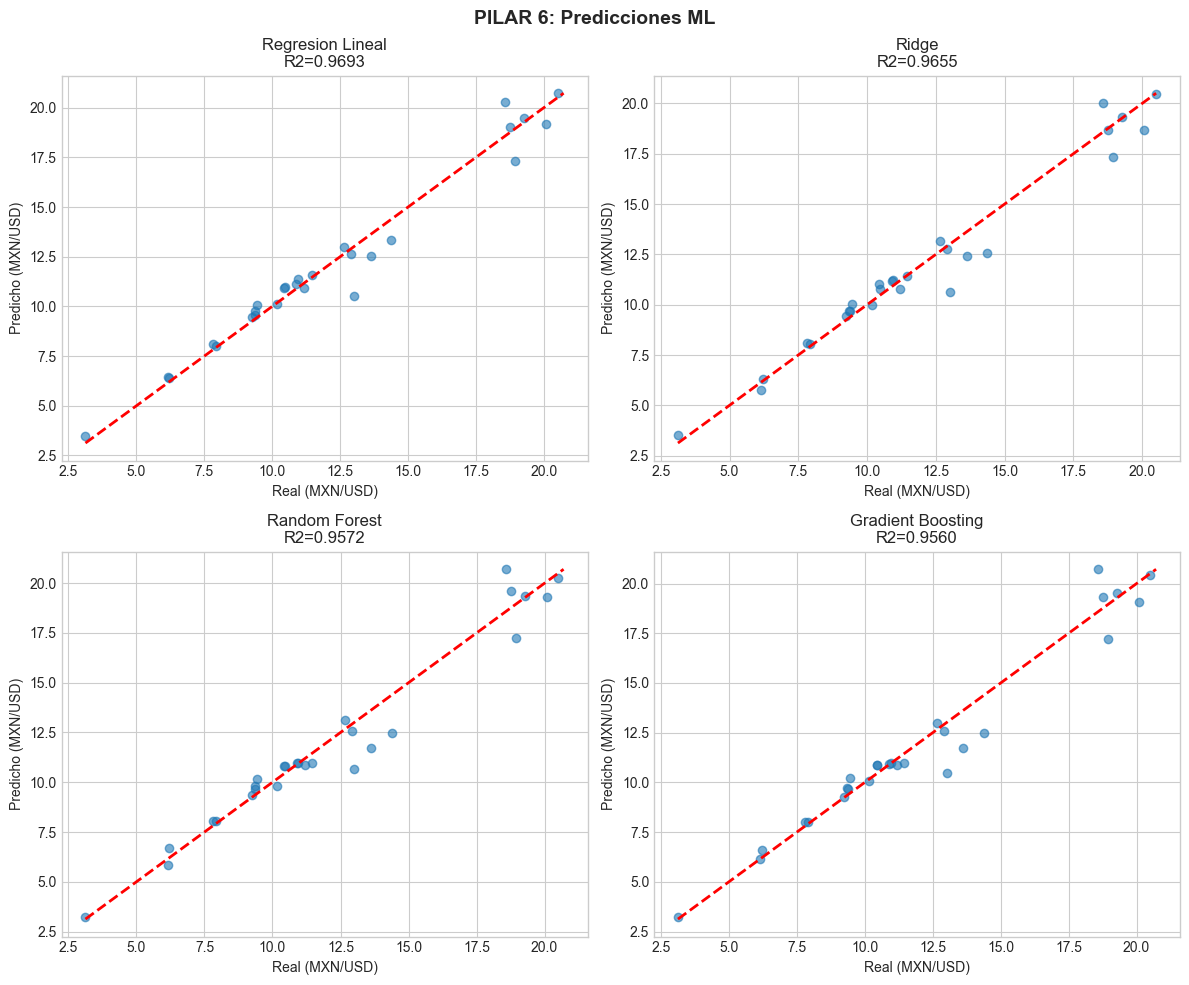

In [15]:
if len(df_ml) >= 20 and len(predicciones) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('PILAR 6: Predicciones ML', fontsize=14, fontweight='bold')
    
    for idx, (nombre, y_pred) in enumerate(predicciones.items()):
        ax = axes[idx // 2, idx % 2]
        ax.scatter(y_test, y_pred, alpha=0.6)
        lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
        ax.plot(lims, lims, 'r--', linewidth=2)
        ax.set_xlabel('Real (MXN/USD)')
        ax.set_ylabel('Predicho (MXN/USD)')
        ax.set_title(f'{nombre}\nR2={r2_score(y_test, y_pred):.4f}')
    
    plt.tight_layout()
    plt.show()

---
## PILAR 7: Series de Tiempo

In [16]:
print("PILAR 7: SERIES DE TIEMPO")
print("="*60)

ts_data = df.set_index('periodo')[VAR_PRINCIPAL].dropna().asfreq('QS')
print(f"Serie: {ts_data.index.min()} a {ts_data.index.max()}")

if len(ts_data.dropna()) >= 10:
    adf_result = adfuller(ts_data.dropna())
    print(f"\nTest ADF (nivel): stat={adf_result[0]:.4f}, p={adf_result[1]:.4f}")
    print(f"{'ESTACIONARIA' if adf_result[1] < 0.05 else 'NO ESTACIONARIA'}")
    
    # Test en diferencias
    ts_diff = ts_data.pct_change().dropna()
    adf_diff = adfuller(ts_diff)
    print(f"\nTest ADF (rendimientos): p={adf_diff[1]:.4f} - {'ESTACIONARIA' if adf_diff[1] < 0.05 else 'NO ESTACIONARIA'}")
else:
    adf_result = [0, 1.0]

PILAR 7: SERIES DE TIEMPO
Serie: 1991-10-01 00:00:00 a 2025-07-01 00:00:00

Test ADF (nivel): stat=-1.4521, p=0.5571
NO ESTACIONARIA

Test ADF (rendimientos): p=0.0000 - ESTACIONARIA


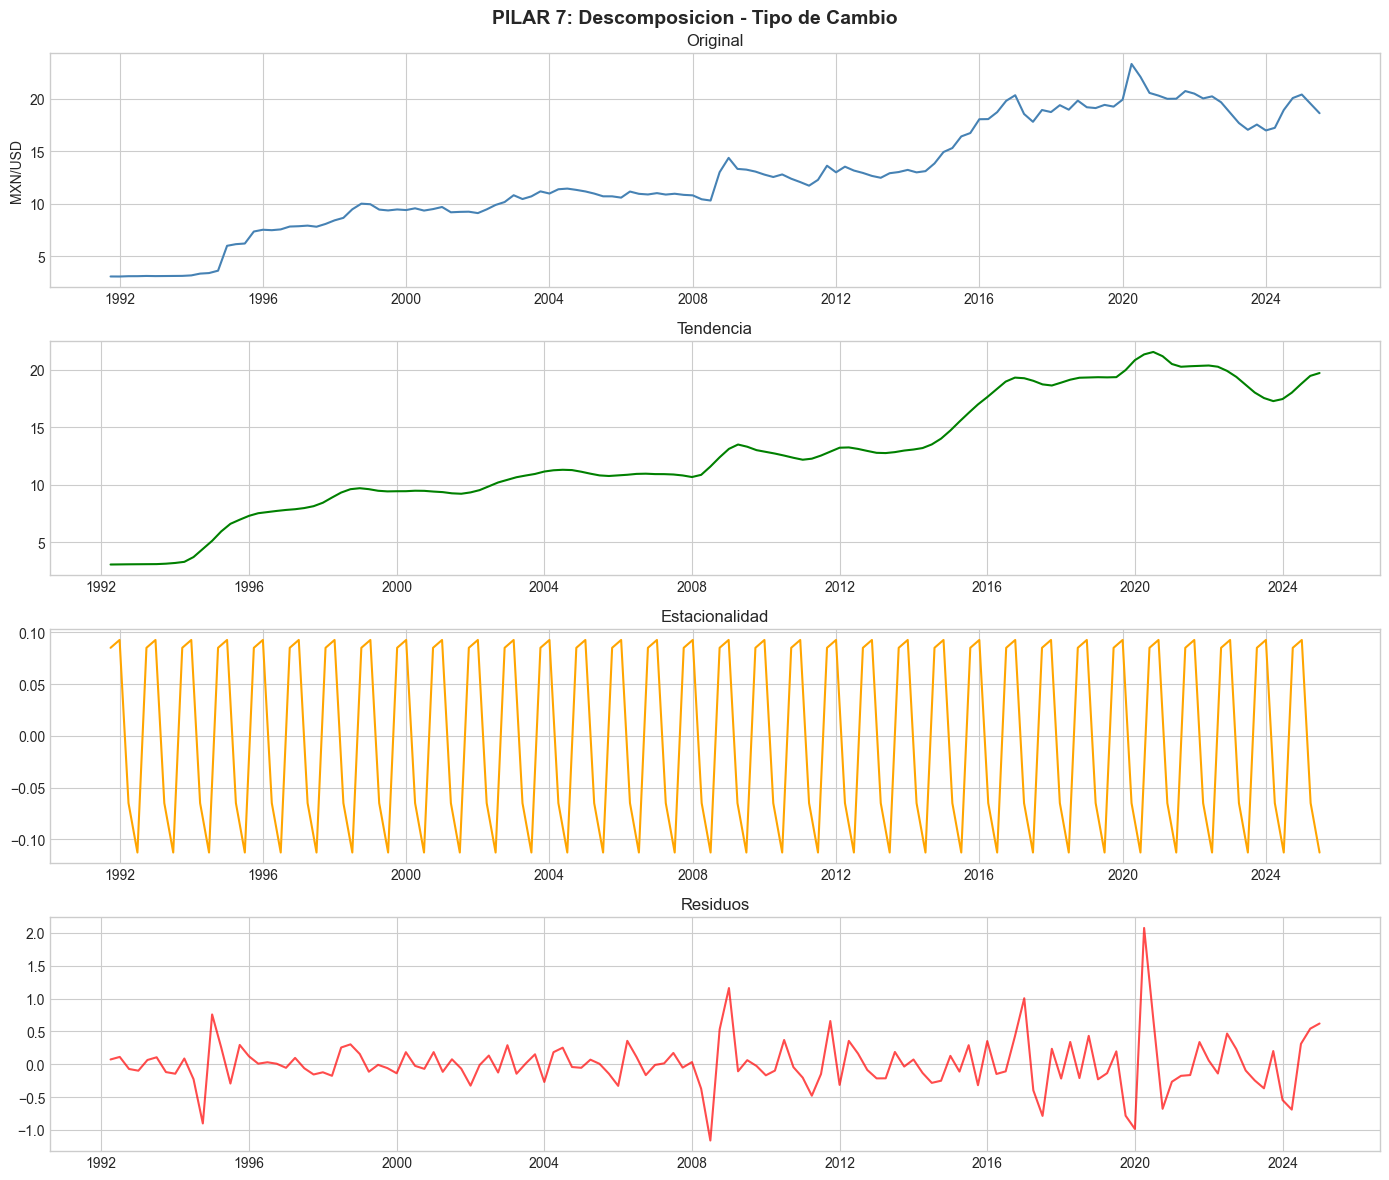

In [17]:
if len(ts_data.dropna()) >= 8:
    # Usar modelo aditivo porque TCN puede tener tendencia fuerte
    decomp = seasonal_decompose(ts_data.dropna(), model='additive', period=4)
    
    fig, axes = plt.subplots(4, 1, figsize=(14, 12))
    fig.suptitle('PILAR 7: Descomposicion - Tipo de Cambio', fontsize=14, fontweight='bold')
    
    axes[0].plot(ts_data, color='steelblue')
    axes[0].set_title('Original')
    axes[0].set_ylabel('MXN/USD')
    
    axes[1].plot(decomp.trend, color='green')
    axes[1].set_title('Tendencia')
    
    axes[2].plot(decomp.seasonal, color='orange')
    axes[2].set_title('Estacionalidad')
    
    axes[3].plot(decomp.resid, color='red', alpha=0.7)
    axes[3].set_title('Residuos')
    
    plt.tight_layout()
    plt.show()

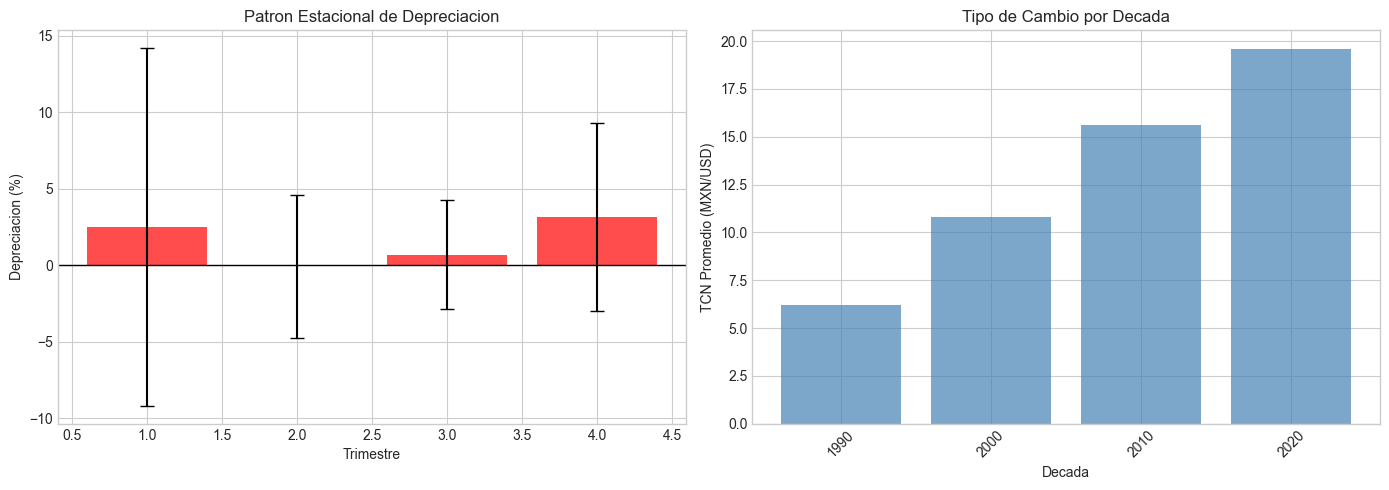

In [18]:
# Patron estacional y por decada
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Por trimestre (depreciacion)
if 'depreciacion_pct' in df.columns:
    patron = df.groupby('TRIMESTRE')['depreciacion_pct'].agg(['mean', 'std'])
    colors = ['red' if m > 0 else 'green' for m in patron['mean']]
    axes[0].bar(patron.index, patron['mean'], yerr=patron['std'], capsize=5, color=colors, alpha=0.7)
    axes[0].axhline(0, color='black', linewidth=1)
    axes[0].set_xlabel('Trimestre')
    axes[0].set_ylabel('Depreciacion (%)')
    axes[0].set_title('Patron Estacional de Depreciacion')

# TCN por decada
df['decada'] = (df['year'] // 10) * 10
prom_dec = df.groupby('decada')[VAR_PRINCIPAL].mean()
axes[1].bar(prom_dec.index.astype(str), prom_dec.values, color='steelblue', alpha=0.7)
axes[1].set_xlabel('Decada')
axes[1].set_ylabel('TCN Promedio (MXN/USD)')
axes[1].set_title('Tipo de Cambio por Decada')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

---
## PILAR 8: ANOVA

In [19]:
print("PILAR 8: ANOVA")
print("="*60)

# Por trimestre (depreciacion)
if 'depreciacion_pct' in df.columns:
    grupos = [df[df['TRIMESTRE'] == t]['depreciacion_pct'].dropna() for t in [1, 2, 3, 4]]
    grupos = [g for g in grupos if len(g) >= 3]
    
    if len(grupos) >= 2:
        f_stat, p_anova = stats.f_oneway(*grupos)
        print(f"Depreciacion por Trimestre: F={f_stat:.4f}, p={p_anova:.4f}")
    else:
        f_stat, p_anova = 0, 1.0
else:
    f_stat, p_anova = 0, 1.0

# TCN por decada
grupos_dec = [df[df['decada'] == d][VAR_PRINCIPAL].dropna() for d in df['decada'].unique()]
grupos_dec = [g for g in grupos_dec if len(g) >= 3]

if len(grupos_dec) >= 2:
    f_stat2, p_anova2 = stats.f_oneway(*grupos_dec)
    print(f"TCN por Decada: F={f_stat2:.4f}, p={p_anova2:.6f}")
else:
    f_stat2, p_anova2 = 0, 1.0

PILAR 8: ANOVA
Depreciacion por Trimestre: F=1.4518, p=0.2308
TCN por Decada: F=190.4939, p=0.000000


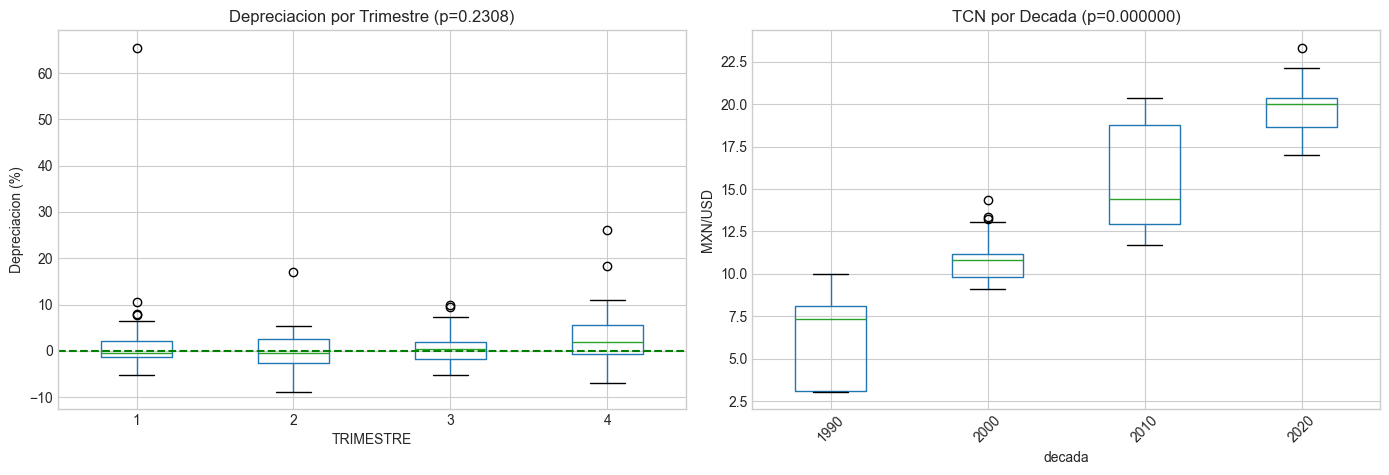

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('PILAR 8: ANOVA', fontsize=14, fontweight='bold')

if 'depreciacion_pct' in df.columns:
    df.boxplot(column='depreciacion_pct', by='TRIMESTRE', ax=axes[0])
    axes[0].axhline(0, color='green', linestyle='--')
    axes[0].set_title(f'Depreciacion por Trimestre (p={p_anova:.4f})')
    axes[0].set_ylabel('Depreciacion (%)')
    plt.suptitle('')

df.boxplot(column=VAR_PRINCIPAL, by='decada', ax=axes[1])
axes[1].set_title(f'TCN por Decada (p={p_anova2:.6f})')
axes[1].set_ylabel('MXN/USD')
axes[1].tick_params(axis='x', rotation=45)
plt.suptitle('')

plt.tight_layout()
plt.show()

---
## RESUMEN EJECUTIVO

In [21]:
print("="*70)
print("RESUMEN: 8 PILARES - TIPO DE CAMBIO")
print("="*70)

print(f"\n1. DISTRIBUCIONES: TCN No Normal (tendencia creciente)")

print(f"\n2. CENTRO DE GRAVEDAD:")
print(f"   - TCN Media Historica: {df[VAR_PRINCIPAL].mean():.2f} MXN/USD")
print(f"   - TCN Actual: {df[VAR_PRINCIPAL].iloc[-1]:.2f} MXN/USD")
if 'depreciacion_pct' in df.columns:
    print(f"   - Depreciacion Prom. Trim: {df['depreciacion_pct'].mean():.2f}%")

print(f"\n3. FIABILIDAD:")
print(f"   - CV TCN: {cv:.1f}%")
if 'depreciacion_pct' in df.columns:
    print(f"   - Volatilidad Dep: {df['depreciacion_pct'].std():.2f}%")

print(f"\n4. MARGEN DE ERROR: Ver IC arriba")

print(f"\n5. CHI-CUADRADA:")
print(f"   - Direccion vs Trimestre: p={p_value:.4f}")
print(f"   - Crisis vs Decada: p={p_value_2:.6f}")

print(f"\n6. ML: {mejor_modelo}")
if len(df_resultados) > 0:
    print(f"   R2={df_resultados.iloc[0]['R2']:.4f}")

print(f"\n7. SERIES: {'ESTACIONARIA' if adf_result[1] < 0.05 else 'NO ESTACIONARIA'} en nivel")

print(f"\n8. ANOVA:")
print(f"   - Depreciacion por Trim: p={p_anova:.4f}")
print(f"   - TCN por Decada: p={p_anova2:.6f}")

print("\n" + "="*70)

RESUMEN: 8 PILARES - TIPO DE CAMBIO

1. DISTRIBUCIONES: TCN No Normal (tendencia creciente)

2. CENTRO DE GRAVEDAD:
   - TCN Media Historica: 12.58 MXN/USD
   - TCN Actual: 18.64 MXN/USD
   - Depreciacion Prom. Trim: 1.56%

3. FIABILIDAD:
   - CV TCN: 41.4%
   - Volatilidad Dep: 7.27%

4. MARGEN DE ERROR: Ver IC arriba

5. CHI-CUADRADA:
   - Direccion vs Trimestre: p=0.2053
   - Crisis vs Decada: p=0.471023

6. ML: Regresion Lineal
   R2=0.9693

7. SERIES: NO ESTACIONARIA en nivel

8. ANOVA:
   - Depreciacion por Trim: p=0.2308
   - TCN por Decada: p=0.000000

